In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import matplotlib.image as mpimg

%matplotlib inline

# Calibrating the camera

### 1. Get points from calibration images

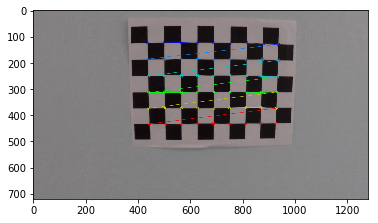

In [2]:
num_corners = [6,9]    # Number of inner corners in calibration images

objp = np.zeros((num_corners[0]*num_corners[1],3), np.float32)
objp[:,:2] = np.mgrid[0:num_corners[1], 0:num_corners[0]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (num_corners[1],num_corners[0]), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (num_corners[1],num_corners[0]), corners, ret)
        clear_output()
        plt.imshow(img)
        plt.show()
        time.sleep(1)

### 2. Calculate and save distortion coefficients

In [4]:
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use.
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/coefficients.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

### 3. Load calibration coefficients

In [2]:
coeff = pickle.load( open( "camera_cal/coefficients.p", "rb" ) )
mtx = coeff['mtx']
dist = coeff['dist']

### 3. Test undistortion on an image

In [3]:
def undistort(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

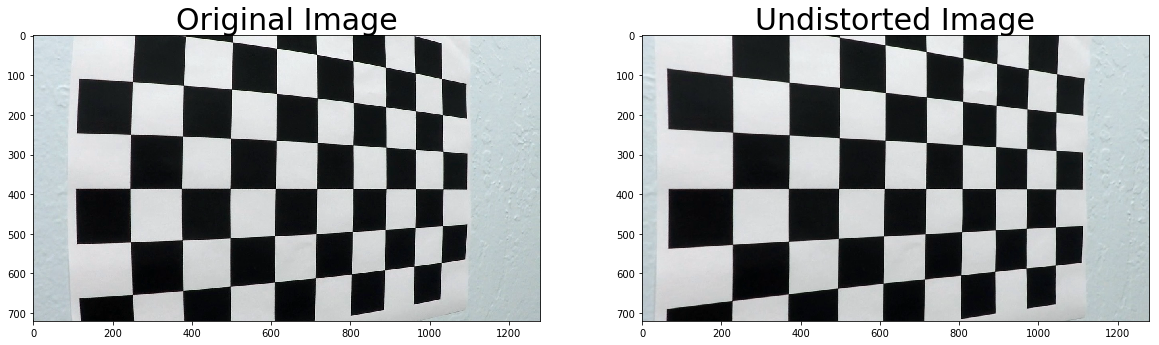

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')

dst = undistort(img,mtx,dist)
cv2.imwrite('examples/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Transform Perspective

In [24]:
def get_eagle_eye(img, src, offset):
    img_size = (img.shape[1],img.shape[0])

    dst = np.float32([[320,720],[320,576],[960,576],[960,720]])
    #dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    # Get the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, dst

In [25]:
def draw_points(img, points):
    img = cv2.line(img, tuple(points[0]), tuple(points[1]), color=(0,0,255), thickness=4)
    img = cv2.line(img, tuple(points[1]), tuple(points[2]), color=(0,0,255), thickness=4)
    img = cv2.line(img, tuple(points[2]), tuple(points[3]), color=(0,0,255), thickness=4)
    img = cv2.line(img, tuple(points[3]), tuple(points[0]), color=(0,0,255), thickness=4)
    return img

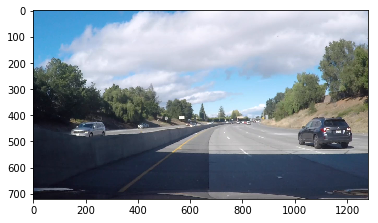

In [63]:
from moviepy.editor import *
video_file = "test_videos/challenge_video.mp4"
video = VideoFileClip(video_file)

#for frame in video.iter_frames():
    #print(frame.shape)

time = 5
original = video.get_frame(time)

plt.imshow(original)

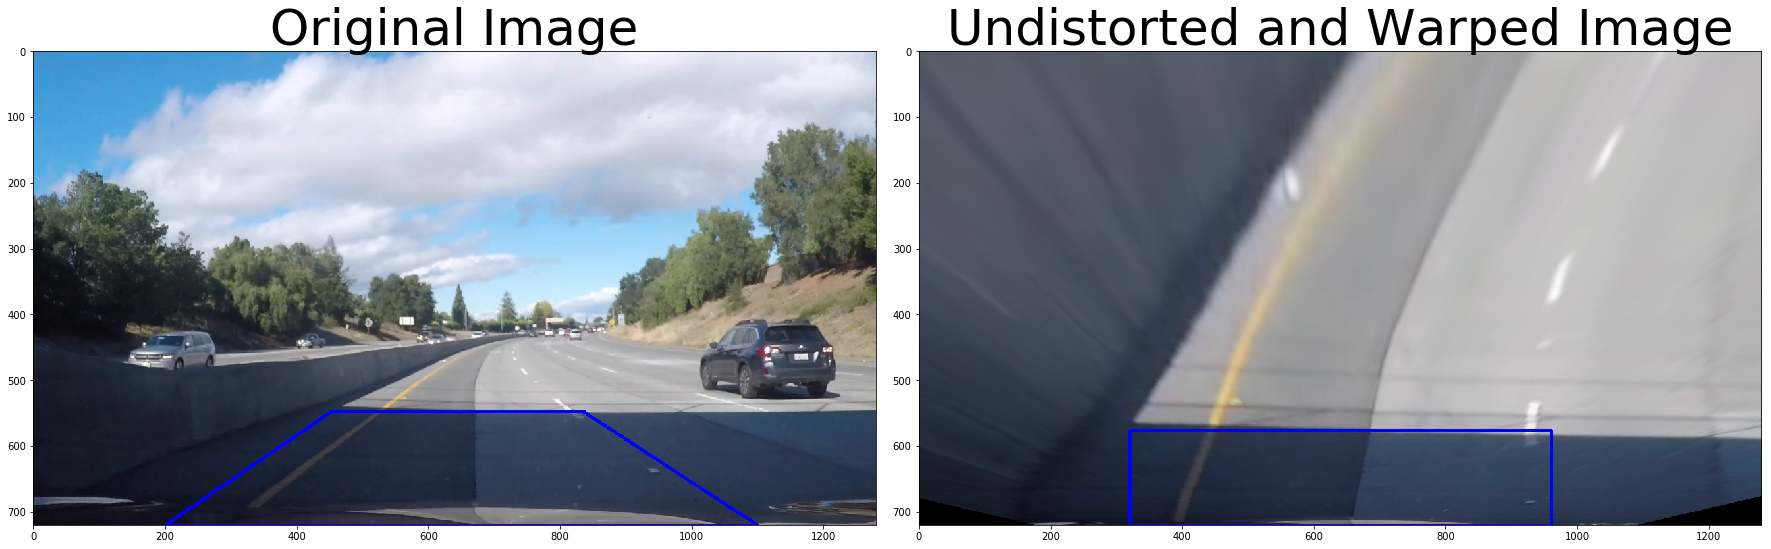

In [62]:
# Read in an image
#img = mpimg.imread('test_images/straight_lines1.jpg')
#original = cv2.imread('test_images/straight_lines2.jpg')
img = undistort(original,mtx,dist)

#src_points = np.float32([[596,447],[685,447],[1115,720],[196,720]])
src_points = np.float32([[200,720],[453,547],[835,547],[1100,720]])
    
top_down, dst_points = get_eagle_eye(img, src_points, 300.0)

original = draw_points(original,src_points)
#original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

top_down = draw_points(top_down,dst_points)
#top_down = cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

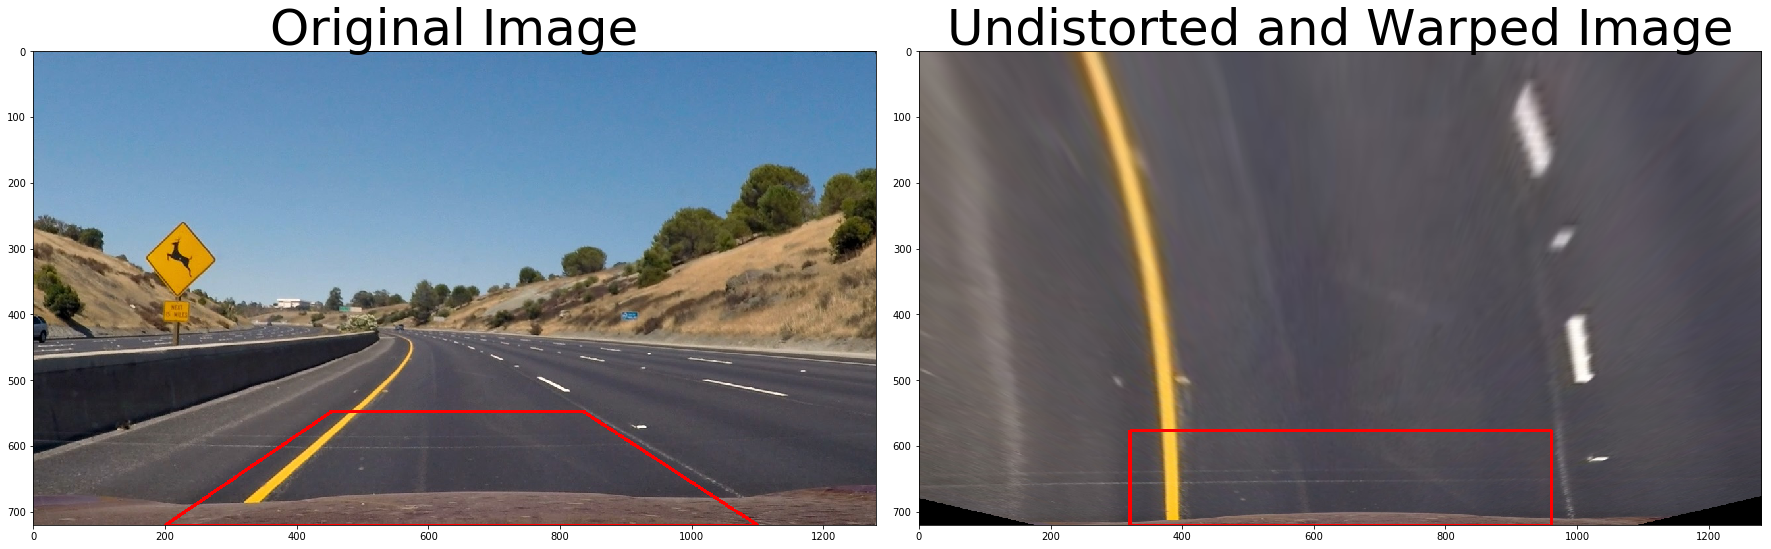

In [20]:
# Read in an image
#img = mpimg.imread('test_images/straight_lines1.jpg')
original = cv2.imread('test_images/test2.jpg')
img = undistort(original,mtx,dist)

top_down, dst_points = get_eagle_eye(img, src_points, 300.0)

original = draw_points(original,src_points)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

top_down = draw_points(top_down,dst_points)
top_down = cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Create a thresholded binary image

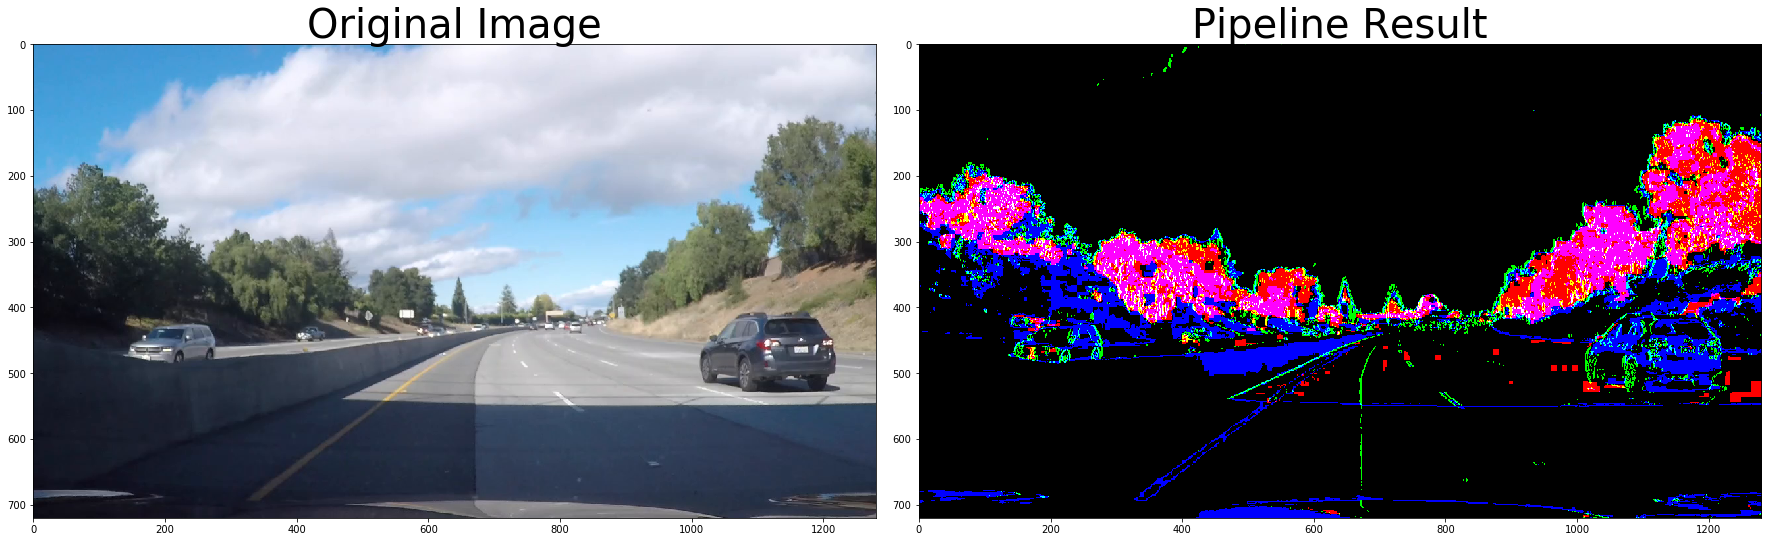

In [104]:
#image = mpimg.imread('test_images/test3.jpg')
image= original
def pipeline(img, s_thresh=(20, 40), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    h_channel = hsv[:,:,0]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= 10) & (scaled_sobely <= 255)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 30) & (h_channel <= 80)] = 1
    
    color_binary = np.dstack(( h_binary, sxbinary, s_binary))
    combined = np.zeros_like(scaled_sobel)
    combined[(sxbinary == 1) | (s_binary == 1)] = 1   # (h_binary == 1) | 
    combined[(sybinary == 1)] = 0
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Pipeline

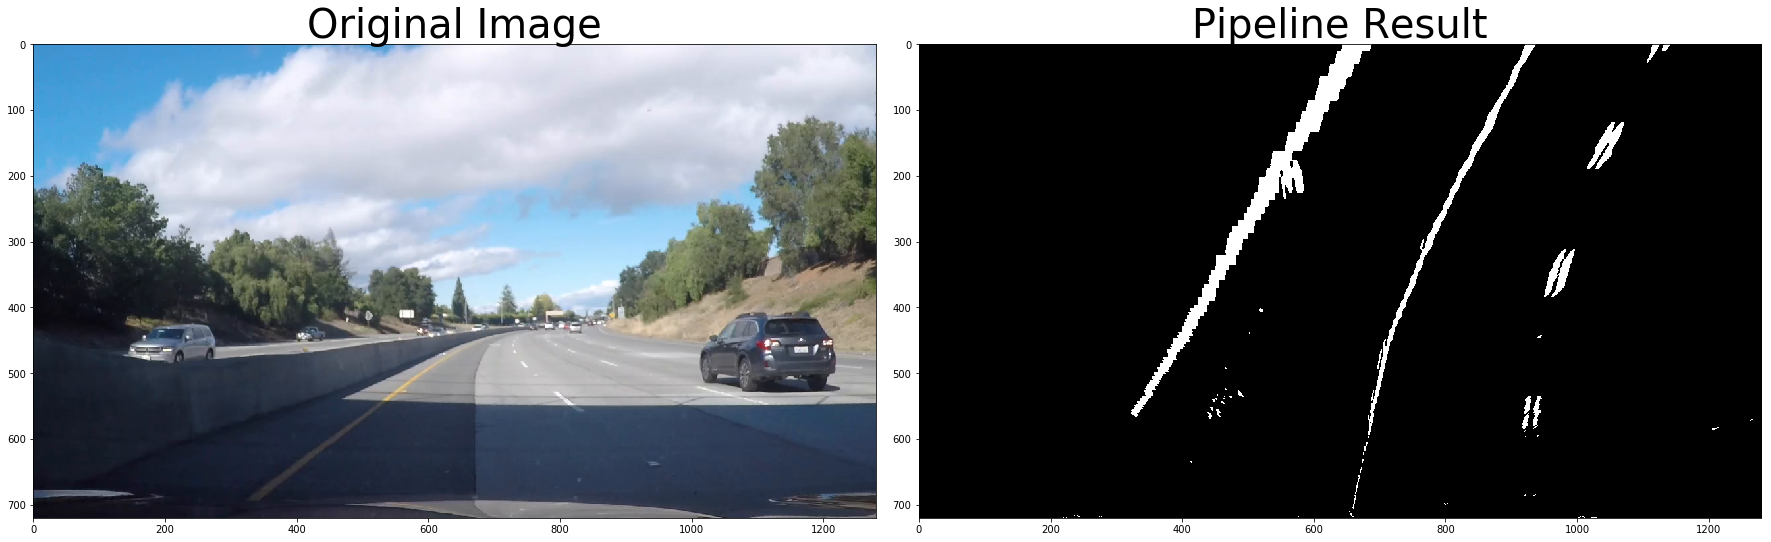

In [48]:
def process_frame(frame,mtx,dist):
    undistorted = undistort(frame,mtx,dist)
    binary = pipeline(undistorted)
    
    src_points = np.float32([[200,720],[453,547],[835,547],[1100,720]])
    top_down, dst_points = get_eagle_eye(binary, src_points, 300.0)
    
    return top_down

#image = mpimg.imread('test_images/test3.jpg')
image= original
top_down = process_frame(image,mtx,dist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(top_down, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [49]:
binary_warped = np.copy(top_down)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 12
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 10
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

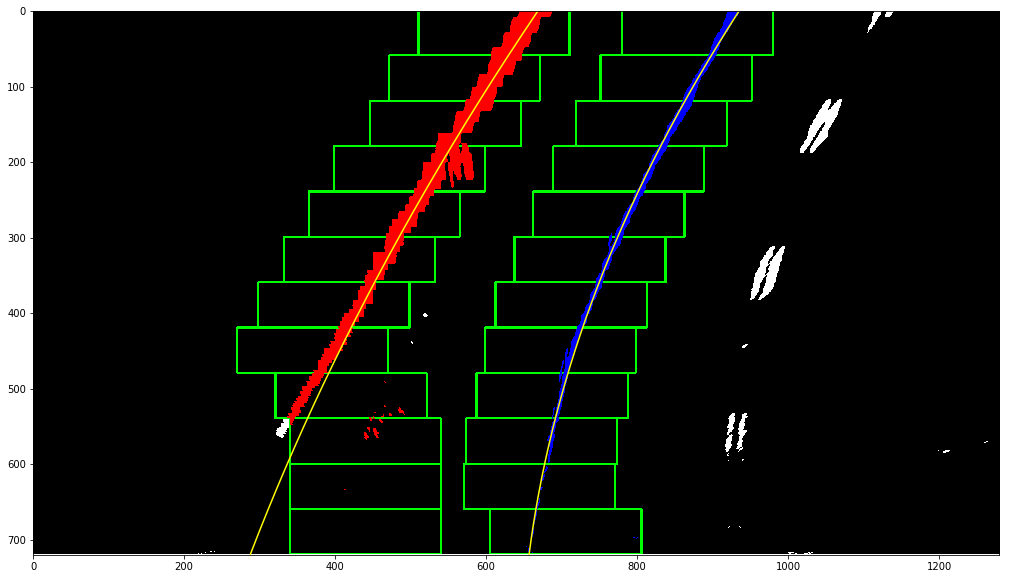

In [50]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


# Radius of Curvature

In [54]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

552.942191145 m 541.430430744 m
